In [23]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2,norm
from scipy.stats import kstest



In [102]:
def plot_chi2(ax, dof, pwr, thresh_pct = 0.95, bins=50, nrv=10240, show_chi2=True):
    # plots a histogram of pwr against theoretical chi square density
    
    nsamples = len(pwr)
    #theorical density
    x = np.linspace(chi2.ppf(0.001,dof), chi2.ppf(0.999,dof), nrv)
    chi_pdf = chi2.pdf(x,dof)

    #cutoff value
    thresh = chi2.ppf(thresh_pct, dof)
    ks_v, ks_p = kstest(pwr,'chi2',[dof])

    ax.hist(pwr, bins=bins, density=True, label='Sample Density', alpha=0.7)
    
    if show_chi2:
        ax.plot(x, chi_pdf, lw=3, color='red', label=f'ChiSquare (dof={dof})')

        lbl = f'Threshold: $\\alpha = {(1-thresh_pct):.2f}$'
        ax.axvline(thresh, ls=':',color='green', lw=3, label=lbl)
    
        ax.text(0.7, 0.75, f'N Values: {nsamples:,}',transform=ax.transAxes)
        ax.text(0.7, 0.70, f'Threshold: {100*thresh_pct} %',transform=ax.transAxes)
        ax.text(0.7, 0.65, f'Threshold Value: {thresh:.2f}',transform=ax.transAxes)
        ax.text(0.7, 0.60, f'Expected over: {int((1-thresh_pct)*nsamples)}',transform=ax.transAxes)
        ax.text(0.7, 0.55, f'Actual Over: {(pwr>=thresh).sum()}',transform=ax.transAxes)
        ax.text(0.7, 0.50, f'KS val: {ks_v:.3f}',transform=ax.transAxes)
        ax.text(0.7, 0.45, f'KS P-val: {ks_p:.3f}',transform=ax.transAxes)
    ax.set_ylabel('Density')
    ax.legend(loc='upper right')

    return None

In [84]:
def standardize(dft):
    #standardizes complext vector dft
    r = dft.real
    c = dft.imag
    r_std = (r-r.mean())/r.std(ddof=1)
    c_std = (c-c.mean())/r.std(ddof=1)
    std = r_std + c_std*1j
    return std


In [99]:
def signal(amp, freq, phase, samp_rate, sig_dur):
    nsamp = samp_rate*sig_dur
    t = np.arange(nsamp)
    sig = amp*np.sin(2*np.pi*(freq/samp_rate)*t + phase)
    return sig

def gaussian_noise(n, noise_sigma=1, noise_mu=0):
    noise = np.random.normal(noise_mu, noise_sigma, n)
    return noise

## Verify Chi Square Functionality

In [60]:
chi2.stats(1024,moments='mv')

(array(1024.), array(2048.))

Chi square mean is $\nu$ and variance is $2\nu$

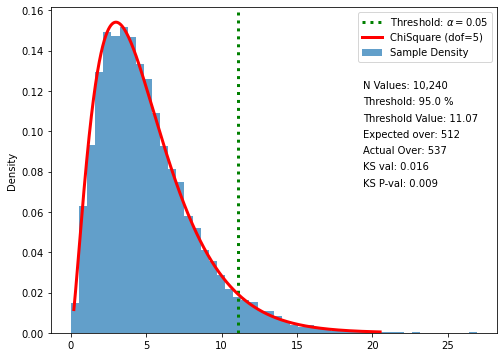

In [93]:
np.random.seed(1234)
nsamples = 10240
doff = 5

xx = chi2.rvs(doff, size=nsamples)
fig, ax = plt.subplots(figsize=(8,6))
plot_chi2(ax, doff, xx)

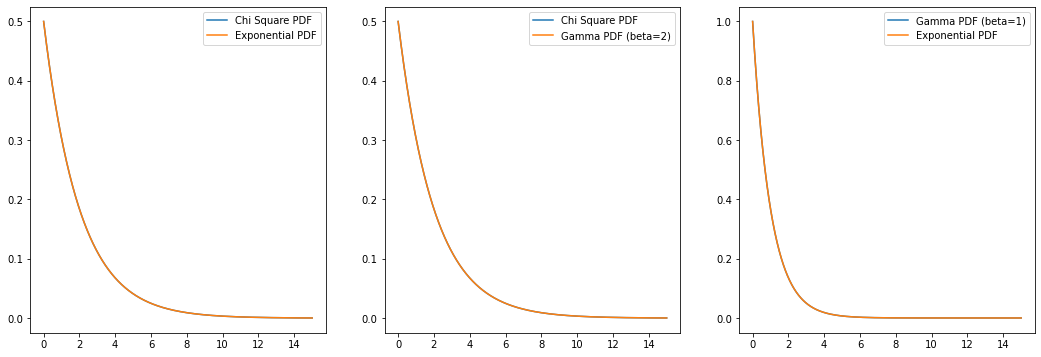

In [10]:
#chi square with dof=2 same as exponential?
doff = 2
from scipy.stats import expon, gamma
fig, axs = plt.subplots(ncols=3, figsize=(18,6))
axs[0].plot(x, chi2.pdf(x,doff), label='Chi Square PDF')
axs[0].plot(x, expon.pdf(x, scale=doff), label='Exponential PDF')
axs[0].legend()

axs[1].plot(x, chi_pdf, label='Chi Square PDF')
axs[1].plot(x, gamma.pdf(x, a=1, scale=2), label='Gamma PDF (beta=2)')
#axs[1].plot(x, expon.pdf(x), label='Exponential PDF')
axs[1].legend()

axs[2].plot(x, gamma.pdf(x, a=1, scale=1), label='Gamma PDF (beta=1)')
axs[2].plot(x, expon.pdf(x), label='Exponential PDF')
axs[2].legend()


Yes, the same.  However, seems to works only for 2 degrees of freedom and the `lambda` parameter needs to be set to `doff`

## Verify DFT Implementation

In [85]:
def dft(sig):
    def coef_a(sig, k):
        n = len(sig)
        m = np.arange(n)
        expn = np.exp(-2.0j*np.pi*m*k/n)
        coef = (sig*expn).sum()
        return coef
    fourier = np.array([coef_a(sig,k) for k in range(len(sig))])
    return fourier


In [86]:
nsamples = 1024
sig = np.random.randn(nsamples)
dft_test = dft(sig)
dft_np = np.fft.fft(sig)
np.allclose(dft_test, dft_np)

True

## Distribution of Fourier Power Follows Chi-Square

Text(0.5, 0, 'Standardized Fourier Power')

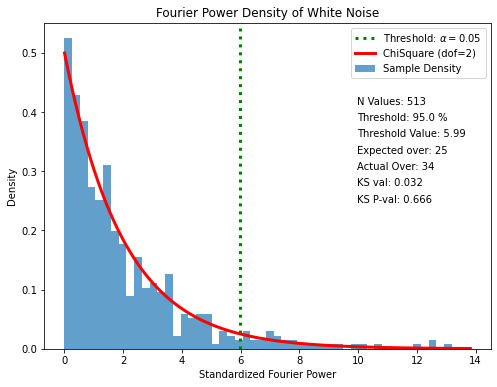

In [101]:
nsamples = 1024
sig = gaussian_noise(n=nsamples)

dft_np = np.fft.rfft(sig)
dft_std = standardize(dft_np)
pwr = np.power(np.abs(dft_std), 2)

fig, ax = plt.subplots(figsize=(8,6))
plot_chi2(ax, 2, pwr)
ax.set_title('Fourier Power Density of White Noise')
ax.set_xlabel('Standardized Fourier Power')


## Normalized and Standardized Fourier Power

Text(0.5, 0, 'Normalized and Standardized Fourier Power')

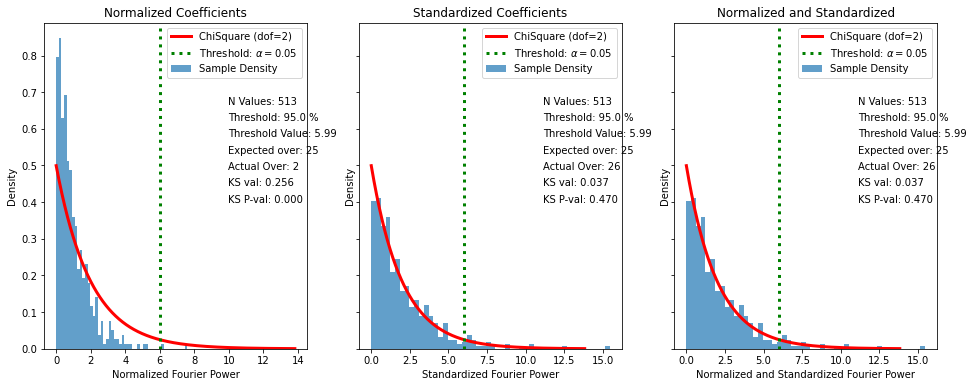

In [107]:
nsamples = 1024
sig = gaussian_noise(n=nsamples)
norm_factor = np.sqrt((sig**2).sum())

dft_np = np.fft.rfft(sig)
dft_norm = dft_np/norm_factor
pwr_norm = np.power(np.abs(dft_norm), 2)

dft_std = standardize(dft_np)
pwr_std = np.power(np.abs(dft_std), 2)

dft_normstd = standardize(dft_norm)
pwr_normstd = np.power(np.abs(dft_normstd), 2)

fig, ax = plt.subplots(ncols=3, figsize=(16,6), sharey=True)
plot_chi2(ax[0], 2, pwr_norm, show_chi2=True)
ax[0].set_title('Normalized Coefficients')
ax[0].set_xlabel('Normalized Fourier Power')

plot_chi2(ax[1], 2, pwr_std, show_chi2=True)
ax[1].set_title('Standardized Coefficients')
ax[1].set_xlabel('Standardized Fourier Power')

plot_chi2(ax[2], 2, pwr_normstd, show_chi2=True)
ax[2].set_title('Normalized and Standardized')
ax[2].set_xlabel('Normalized and Standardized Fourier Power')

In order to get the expected Chi Square distribution, we need at least to standardize the coefficients. Normalizing does not affect the power density since it is dividing each coefficient by the normalizing scalar.

## Distribution of Total Power

Fourier power, which for frequency bin $i$, is the squared magnitude of the $i$ Fourier coefficent. Both the real and imaginary parts of the coefficients are linear combinations of the samples that comprise the input signal.  If the signal is gaussian noise, the real and imaginary parts of the squared coefficients will be distributed Chi-square, each with one degree of freedom. The sum of the squared coefficients, i.e, the Fourier power in frequency bin $i$, is therefore Chi-square with two degrees of freedom.

If we sum the power over the spectrum (i.e. all of the power values), the distribution of the sum is also Chi-square distributed with 2n degrees of freedom, where n is the number of coefficients.

**TODO** The above assumes the input signal is $\sim N(0,1)$. What happens if this assumption is not met?

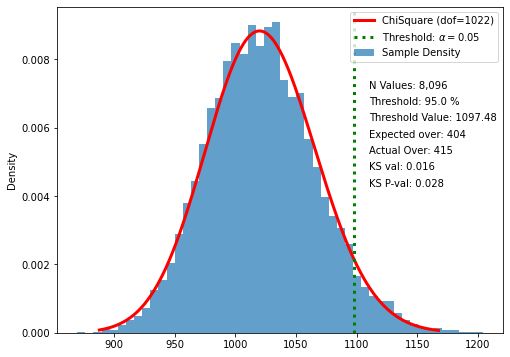

In [134]:
#np.random.seed(1234)

def tot_pwr(siglen):
    sig = gaussian_noise(siglen)
    dft = standardize(np.fft.rfft(sig))
    pwr = (np.concatenate([dft.real, dft.imag])**2).sum()
    return pwr
NSIG=8096
SIGLEN = 1024
dof = 2*((SIGLEN//2)+1)-4

pwr = np.array([tot_pwr(SIGLEN) for i in range(NSIG)])
fig, ax = plt.subplots(figsize=(8,6))
plot_chi2(ax, dof, pwr)


In [113]:
(SIGLEN//2)+1

513

Text(0.5, 0.6, 'KS P-val: 0.609')

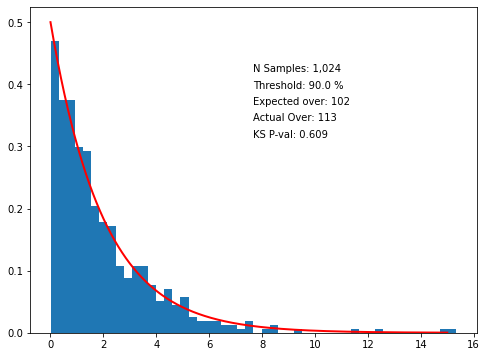

In [38]:
thresh_pct = 0.90
doff = 2
xx = chi2.rvs(doff, size=nsamples)
x = np.linspace(0, 15, 10000)
chi_pdf = chi2.pdf(x,doff)
thresh = chi2.ppf(thresh_pct, doff)
ks_p = kstest(xx,'chi2',[doff])[1]
fig, ax = plt.subplots(figsize=(8,6))
zz = ax.hist(pwr, bins=50, density=True)
ax.plot(x, chi_pdf, lw=2, color='red')
ax.text(0.5, 0.80, f'N Samples: {nsamples:,}',transform=ax.transAxes)
ax.text(0.5, 0.75, f'Threshold: {100*thresh_pct} %',transform=ax.transAxes)
ax.text(0.5, 0.70, f'Expected over: {int((1-thresh_pct)*nsamples)}',transform=ax.transAxes)
ax.text(0.5, 0.65, f'Actual Over: {(xx>=thresh).sum()}',transform=ax.transAxes)
ax.text(0.5, 0.60, f'KS P-val: {ks_p:.3f}',transform=ax.transAxes)

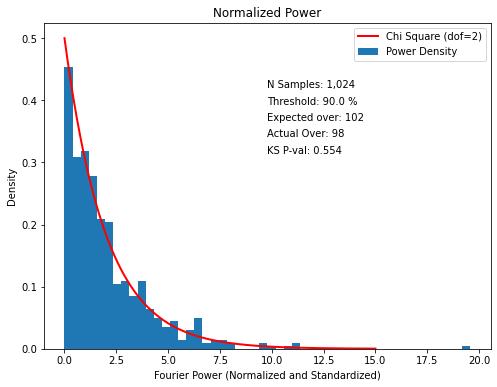

In [52]:
nsamples = 1024
sig = np.random.randn(nsamples)

norm_factor = np.sqrt((sig**2).sum())
dft_np = np.fft.rfft(sig)
dft_std = standardize(dft_np/norm_factor)
pwr = np.power(np.abs(dft_std), 2)


thresh_pct = 0.90
doff = 2
xx = chi2.rvs(doff, size=nsamples)
x = np.linspace(0, 15, 10000)
chi_pdf = chi2.pdf(x,doff)
thresh = chi2.ppf(thresh_pct, doff)
ks_p = kstest(pwr,'chi2',[doff])[1]
fig, ax = plt.subplots(figsize=(8,6))
zz = ax.hist(pwr, bins=50, density=True, label='Power Density')
ax.plot(x, chi_pdf, lw=2, color='red', label=f'Chi Square (dof={doff})')
ax.text(0.5, 0.80, f'N Samples: {nsamples:,}',transform=ax.transAxes)
ax.text(0.5, 0.75, f'Threshold: {100*thresh_pct} %',transform=ax.transAxes)
ax.text(0.5, 0.70, f'Expected over: {int((1-thresh_pct)*nsamples)}',transform=ax.transAxes)
ax.text(0.5, 0.65, f'Actual Over: {(xx>=thresh).sum()}',transform=ax.transAxes)
ax.text(0.5, 0.60, f'KS P-val: {ks_p:.3f}',transform=ax.transAxes)
ax.set_title('Normalized Power')
ax.set_xlabel('Fourier Power (Normalized and Standardized)')
ax.set_ylabel('Density')
ax.legend(loc='upper right')

Text(0.5, 1.0, 'Fourier Power (Standardized)')

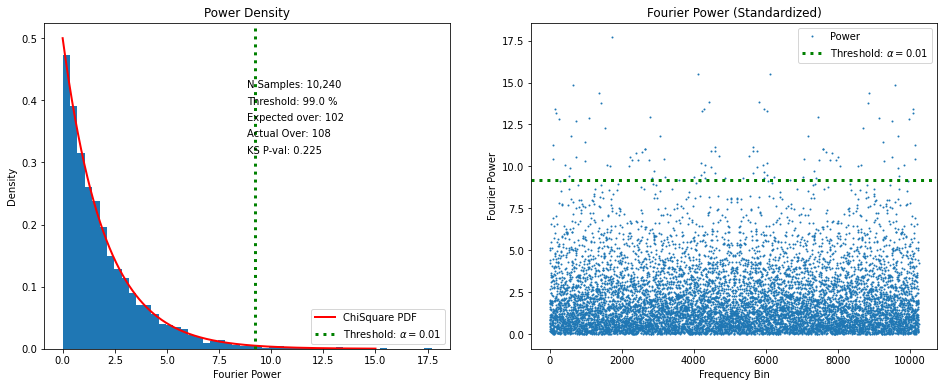

In [57]:
#np.random.seed(1234)
nsamples = 10240
doff = 2

sig = np.random.randn(nsamples)
norm_factor = np.sqrt((sig**2).sum())
norm_factor=1.0
dft = np.fft.fft(sig)/norm_factor
dft_std = standardize(dft)
pwr = np.power(np.abs(dft_std),2)
ks_p = kstest(pwr,'chi2',[doff])[1]

thresh_pct = 0.99
xx = chi2.rvs(doff, size=nsamples)
x = np.linspace(0, 15, 10000)
chi_pdf = chi2.pdf(x,doff)
thresh = chi2.ppf(thresh_pct, doff)
lbl = f'Threshold: $\\alpha = {(1-thresh_pct):.2f}$'


fig, axs = plt.subplots(ncols=2, figsize=(16,6))
ax=axs[0]
zz = ax.hist(pwr, bins=50, density=True)
ax.plot(x, chi_pdf, lw=2, color='red', label='ChiSquare PDF')

ax.axvline(thresh, ls=':',color='green', lw=3, label=lbl)
ax.text(0.5, 0.80, f'N Samples: {nsamples:,}',transform=ax.transAxes)
ax.text(0.5, 0.75, f'Threshold: {100*thresh_pct} %',transform=ax.transAxes)
ax.text(0.5, 0.70, f'Expected over: {int((1-thresh_pct)*nsamples)}',transform=ax.transAxes)
ax.text(0.5, 0.65, f'Actual Over: {(xx>=thresh).sum()}',transform=ax.transAxes)
ax.text(0.5, 0.60, f'KS P-val: {ks_p:.3f}',transform=ax.transAxes)
ax.set_xlabel('Fourier Power')
ax.set_ylabel('Density')
ax.set_title('Power Density')
ax.legend(loc='lower right')

ax = axs[1]
ax.plot(pwr, ls='None', marker='.', markersize=2, label='Power')
ax.axhline(thresh, color='green', ls=':', lw=3, label=lbl)
ax.set_ylabel('Fourier Power')
ax.set_xlabel('Frequency Bin')
ax.legend(loc='upper right')
ax.set_title('Fourier Power (Standardized)')

## Signals with Something in Them

In [18]:
def signal(amp, freq, phase, samp_rate, sig_dur):
    nsamp = samp_rate*sig_dur
    t = np.arange(nsamp)
    sig = amp*np.sin(2*np.pi*(freq/samp_rate)*t + phase)
    return sig

def gaussian_noise(n, noise_sigma=1, noise_mu=0):
    noise = np.random.normal(noise_mu, noise_sigma, n)
    return noise

In [19]:
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
def plot_signal(ax, sig, sample_rate=1024, plot_width=4):
    ax.plot(sig)

    #for i in range(plot_width):
    #    ax.axvline(sample_rate*i, ls=':', color='red')

    ax.set_xticks([sample_rate*i for i in range(plot_width+1)])
    ax.set_xticklabels([str(i) for i in range(plot_width+1)])
    ax.xaxis.set_minor_locator(MultipleLocator(sample_rate/4))

    #ax.tick_params(which='both', width=2)
    ax.tick_params(which='minor', length=3)
    ax.tick_params(which='major', length=7)
    ax.xaxis.grid(True, which='major')
    ax.set_xlim(0, plot_width*sample_rate)
    ax.set_xlabel('Time (Seconds)')

In [20]:
amp = 4
sig = signal(amp, 25, 0, 1024, 5)+signal(amp, 8, 0, 1024, 5)+signal(amp, 60, 0, 1024, 5) + signal(amp, 0.25, 0, 1024, 5)
sig += gaussian_noise(len(sig), 3*amp)

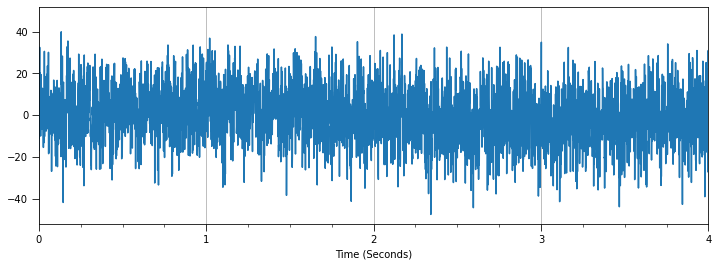

In [21]:
fig, ax = plt.subplots(figsize=(12,4))

plot_signal(ax, sig)

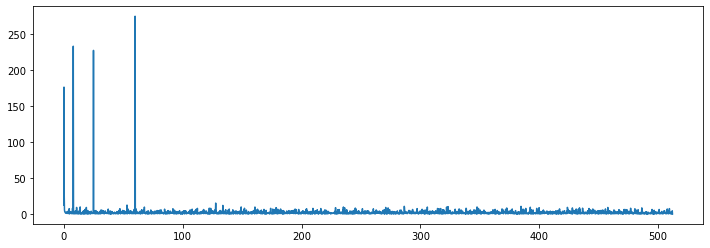

In [22]:
dft = np.fft.rfft(sig)
dft_std = standardize(dft)
pwr = np.power(np.abs(dft_std),2)
freqs = np.fft.rfftfreq(len(sig), d=1/1024)
fig, ax = plt.subplots( figsize=(12,4))
ax.plot(freqs, pwr)

## Analysis of Fourier Coefficints

$$
a_k = \sum_{j=0}^{N-1}x_j e^{-2\pi i j k/N} \ \ \ \ \ \ \text{for}\ k\ =\ 0,\ 1,\ ...\ N-1
$$

Complex exponential:
$$
e^{ix} = \cos x + i \sin x
$$

with $x$ in radians

In [23]:
N=16
expnt = np.array([2*np.pi*k/N *np.arange(N) for k in range(N)])

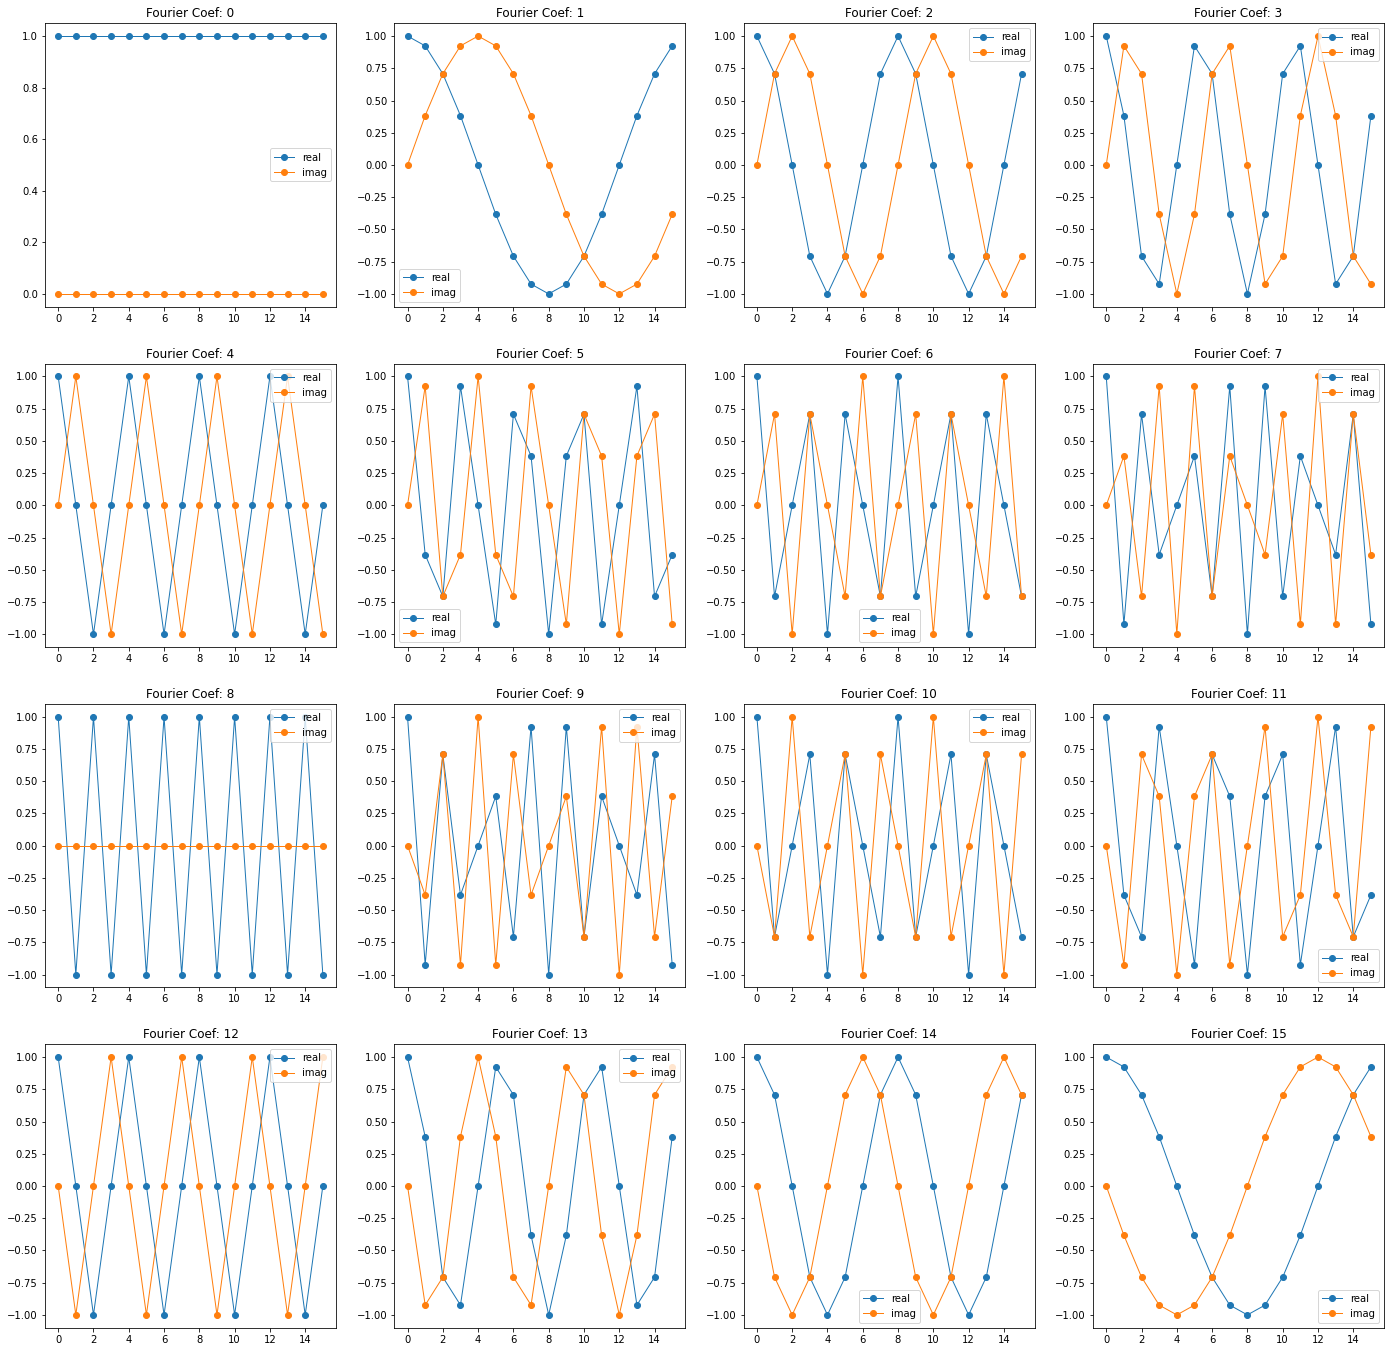

In [24]:
fig, axs = plt.subplots(ncols=4, nrows=4, figsize=(24,24))
for a, ax in zip(range(N), axs.flatten()):
    ax.plot(np.cos(expnt[a]), lw=1, marker='o', label='real')
    ax.plot(np.sin(expnt[a]), lw=1, marker='o', label='imag')
    ax.set_title(f'Fourier Coef: {a}')
    ax.legend()

## Distribution of Fourier Coefficients

In [25]:
from scipy.stats import norm
from scipy.stats import kstest

def coef_hist(axs, coefs, bins=50):

    xx = np.linspace(-3.5, 3.5, 1000)
    std_norm = norm.pdf(xx)

    coef_s = standardize(coefs)

    coef_d = {'Real': coef_s.real, 'Imaginary': coef_s.imag}

    for ax, c in zip( axs, coef_d):
        ax.plot(xx, std_norm, lw=3, color='green', label='Standard Normal')
        cs = coef_d[c]
        pstat = kstest(cs,'norm')[1]
        ax.text(0.05, 0.95, f'KS P-value: {pstat:.2e}',transform=ax.transAxes)

        ax.hist(cs, bins=bins, density=True, alpha=0.5, label='Coef Density')
        m = cs.mean()
        sd = cs.std(ddof=1)

        # ax.axvline(m, ls='solid', lw=3, color='red')
        # ax.axvline(m-sd, ls=':', lw=1, color='red')
        # ax.axvline(m+sd, ls=':', lw=1, color='red')
        ax.set_title(f'Part: {c}')
        ax.legend()


        

In [26]:
nsamples=1024
nsignals = 1024
mu = 10
sigma = 3
sig = np.random.normal(loc=mu, scale=sigma, size=nsamples*nsignals).reshape(nsignals, nsamples)
dft = np.fft.rfft(sig)
dft.shape

(1024, 513)

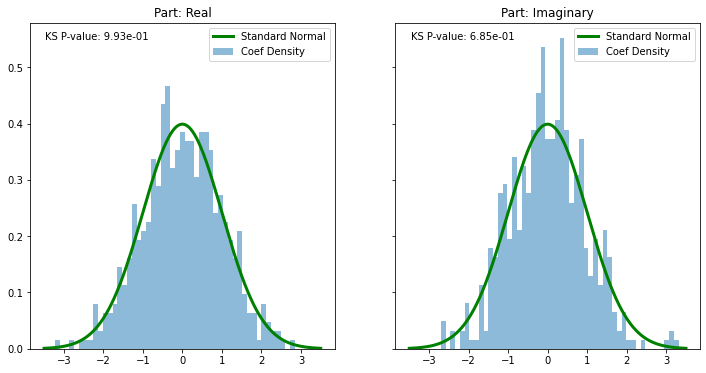

In [27]:
fig, axs = plt.subplots( ncols= 2, figsize=(12,6), sharex=True, sharey=True)

coef_hist(axs, dft[1,1:])

In [28]:
amp = 4
sig_dur = 5
sig = np.array([ signal(amp, 25, 0, nsamples, sig_dur)+
                 signal(amp, 8, 0, nsamples, sig_dur)+
                 signal(amp, 60, 0, nsamples, sig_dur)+
                 signal(amp, 0.25, 0, nsamples, sig_dur)+
                 gaussian_noise(nsamples*sig_dur, 3*amp) for i in range(nsignals)])

In [29]:
dft = np.fft.rfft(sig)
dft.shape

(1024, 2561)

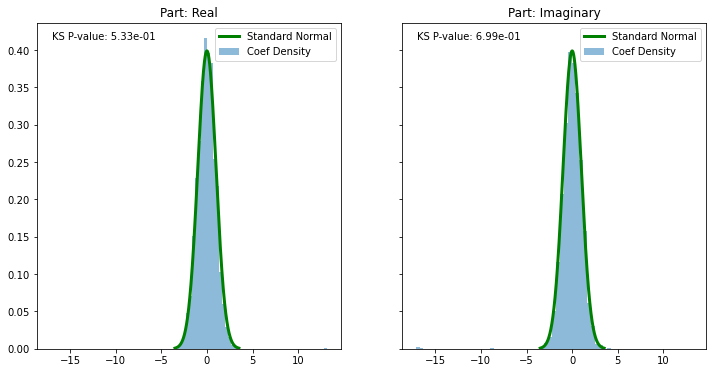

In [30]:
fig, axs = plt.subplots( ncols= 2, figsize=(12,6), sharex=True, sharey=True)

coef_hist(axs, dft[33,1:])

(0.0, 50.0)

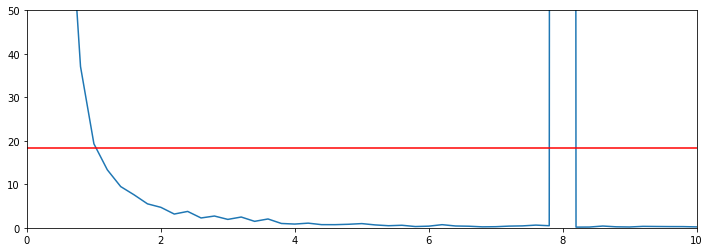

In [31]:
alpha=0.0001
mean_dft = dft.mean(axis=0)
thresh = chi2.ppf(1-alpha, 2)
pwr = np.power(np.abs(standardize(mean_dft)),2)
freqs = np.fft.rfftfreq(sig.shape[1], d=1/1024)
fig, ax = plt.subplots( figsize=(12,4))
ax.plot(freqs[1:], pwr[1:])
ax.axhline(thresh, color='red')
ax.set_xlim(0,10)
ax.set_ylim(0,50)


In [32]:
def analyze_coefs(dft, alpha=0.0001):
    pw_std = np.power(np.abs(standardize(dft[1:])),2) #ignore zero freq coef
   
    thresh = chi2.ppf(1-alpha, 2)
    signif_coefs = np.where(pwr > thresh)[0]  # cuz we skipped the zero freq

    return signif_coefs


In [33]:
zz=analyze_coefs(mean_dft)

In [34]:
freqs[zz]

array([ 0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  8. , 25. , 60. ])

In [35]:
mean_dft.shape

(2561,)

In [36]:
from scipy.stats import kstest

In [37]:
kstest(standardize(dft[:,6]).real, 'norm')

KstestResult(statistic=0.019631070803203865, pvalue=0.8173569229232446)

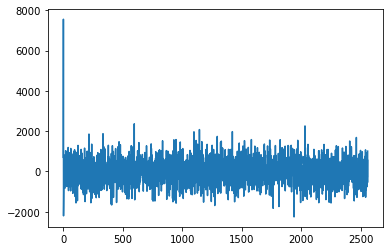

In [38]:
plt.plot(dft[6].real)

In [84]:
nsignals = 2048
nsamples = 1024
sig_dur = 1
amp = 4
noise_amp_multiple=1.0
signals = {'whitenoise': np.array([gaussian_noise(nsamples, amp*noise_amp_multiple) for i in range(nsignals)]),
            'hz25': np.array([ signal(amp, 25, 0, nsamples, sig_dur) +
                  signal(amp, 8, 0, nsamples, sig_dur)+
                  signal(amp, 60, 0, nsamples, sig_dur)+
                  #signal(amp, 0.25, 0, nsamples, sig_dur)+
                  gaussian_noise(nsamples*sig_dur, amp*noise_amp_multiple) for i in range(nsignals)])
}
 
dft = {}
for sigtype in signals:
    dft[sigtype] = {'dft':np.fft.rfft(signals[sigtype])}
    dft[sigtype]['dft_std']= np.array([standardize(d) for d in dft[sigtype]['dft']])
    dft[sigtype]['pwr_sum'] = np.array([(np.concatenate([d.real[1:], d.imag[1:]])**2).sum() for d in dft[sigtype]['dft_std']])

verify that the sum of the power is chi-square with 513 dof.

Text(0.5, 1.0, 'Distribution of Total Fourier Power')

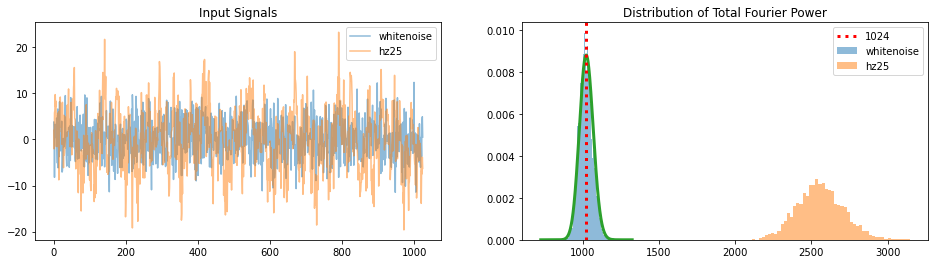

In [85]:
doff = (dft_std.shape[1]-1)*2
x = np.linspace(1024-300, 1024+300, 10000)
chi_pdf = chi2.pdf(x,doff)

fig, axs= plt.subplots( ncols=2, figsize=(16,4))
ax = axs[0]
ax.plot(signals['whitenoise'][33], label='whitenoise', alpha=0.5)
ax.plot(signals['hz25'][33], label='hz25', alpha=0.5)
ax.set_title('Input Signals')
ax.legend(loc='upper right')

ax=axs[1]
for sigtype in dft:
    zz=ax.hist(dft[sigtype]['pwr_sum'], bins=50, density=True, alpha=0.5, label=sigtype)
ax.plot(x, chi_pdf, lw=3)
ax.axvline(1024, lw=3, color='red', ls=':', label='1024')
ax.legend(loc='upper right')
ax.set_title('Distribution of Total Fourier Power')

In [61]:
x[chi_pdf.argmax()]

1021.9897989798981

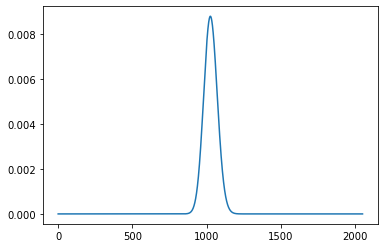

In [63]:
doff = dft_std.shape[1]*2
x = np.linspace(0, 2048, 10000)
chi_pdf = chi2.pdf(x,doff)
plt.plot(x, chi_pdf)

In [97]:
def pulse_profile(pulse_length, pulse_type='gaussian', pulse_sigma=2):
    if pulse_type == 'square':
        pulse = np.ones(pulse_length)
    elif pulse_type == 'left triangle':
        pulse = np.linspace(1,0, pulse_length)
    elif pulse_type == 'right triangle':
        pulse = np.linspace(0,1, pulse_length)
    elif pulse_type == 'triangle':
        nleft = pulse_length//2
        nright = pulse_length-nleft
        pulse = np.concatenate([np.linspace(0,1, nleft, endpoint=False), np.linspace(1,0, nright)])
    elif pulse_type == 'gaussian':
        x = np.linspace(-10, 10, pulse_length)
        pulse = np.exp(-x**2/(2*(pulse_sigma**2)))
    else:
        raise ValueError(f'Invalid pulse_type: {pulse_type}')

    return pulse

from scipy.stats import norm
def sig_gen(pulse_period, pulse_width = 0.05, sig_dur = 300,
            phase=np.pi, sample_rate = 1024, peaks = True,
            bias = 0.0, noise_sigma=0.05,
            pulse_type = 'gaussian', pulse_sigma=3):
    """
    pulse_period: float, pulse period in seconds
    pulse_width: float, percentage of cycle that the pulse occupies
    sig_dur: signal duration in seconds
    phase: where (in radians) pulse occurs in period
    sample_rate: int, samples per unit time (seconds)
    peaks: whether pulses go up or down
    bias: amount by which to move the signal up or down
    noise_signma: standard deviation of noise component
    pulse_type: profile of pulse: gaussian, triangle or square
    pulse_sigma: how wide pulse should be in pulse_width (only for gaussian profile)
    """

    if phase < 0.0 and phase > 2*np.pi:
            raise ValueError('Phase must be between 0 and 2 pi')

    #create a single pulse period
    samples_per_pulseperiod = int(sample_rate*pulse_period)
    samples_per_pulse = int(samples_per_pulseperiod*pulse_width)
    padleft = (samples_per_pulseperiod-samples_per_pulse)//2
    padright = samples_per_pulseperiod - samples_per_pulse - padleft
    polarity = 1 if peaks else -1
    pulse = polarity*pulse_profile(samples_per_pulse, pulse_type=pulse_type, pulse_sigma=pulse_sigma)
    sig_period = np.pad(pulse, (padleft, padright)) # pulse is in the middle of the period (at pi radians)

    #adjust the phase
    pulse_radians_per_sample = 2*np.pi/samples_per_pulseperiod
    phi = phase - np.pi # radians to offset from middle of pulse period
    phase_offset = int(phi/pulse_radians_per_sample)
    sig_period = np.roll(sig_period, phase_offset)

    # string the periods together for the duration of the signal
    nperiods = int(sig_dur/pulse_period)
    sig = np.tile(sig_period, nperiods)

    # tack on the requisite noise
    #sig += norm.rvs(size=len(sig), loc=bias, scale=noise_sigma)
    
    sig+= gaussian_noise(len(sig), noise_sigma=noise_sigma, noise_mu=bias)

    return sig


In [103]:
nsignals = 512
nsamples = 1024
sig_dur = 10
amp = 1
noise_amp_multiple=1.0
signals = {'whitenoise': np.array([gaussian_noise(nsamples*sig_dur, amp*noise_amp_multiple) for i in range(nsignals)]),
            'pulsar': np.array([sig_gen(0.7, pulse_width=0.1, noise_sigma = amp*noise_amp_multiple, sig_dur=sig_dur, peaks=False) for i in range(nsignals)])
}
 
dft = {}
for sigtype in signals:
    dft[sigtype] = {'dft':np.fft.rfft(signals[sigtype])}
    dft[sigtype]['dft_std']= np.array([standardize(d) for d in dft[sigtype]['dft']])
    dft[sigtype]['pwr_sum'] = np.array([(np.concatenate([d.real[1:], d.imag[1:]])**2).sum() for d in dft[sigtype]['dft_std']])

Text(0.5, 1.0, 'Distribution of Total Fourier Power')

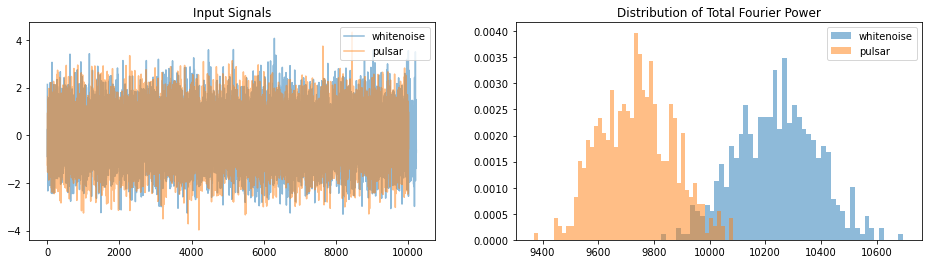

In [104]:
doff = (dft_std.shape[1]-1)*2
x = np.linspace(1024-300, 1024+300, 10000)
chi_pdf = chi2.pdf(x,doff)

fig, axs= plt.subplots( ncols=2, figsize=(16,4))
ax = axs[0]
ax.plot(signals['whitenoise'][33], label='whitenoise', alpha=0.5)
ax.plot(signals['pulsar'][33], label='pulsar', alpha=0.5)
ax.set_title('Input Signals')
ax.legend(loc='upper right')

ax=axs[1]
for sigtype in dft:
    zz=ax.hist(dft[sigtype]['pwr_sum'], bins=50, density=True, alpha=0.5, label=sigtype)
#ax.plot(x, chi_pdf, lw=3)
#ax.axvline(1024, lw=3, color='red', ls=':', label='1024')
ax.legend(loc='upper right')
ax.set_title('Distribution of Total Fourier Power')